# Preparing bathymetry and land-sea mask
The land-sea mask is an essential input in `DIVAnd`, as it indicates where the interpolation has to be performed.      
The most straightforward method to build the mask is to rely on a bathymetry.

In [1]:
using DIVAnd
using Dates
using Statistics
using Makie, CairoMakie, GeoMakie
include("../config.jl")

[ Info: Precompiling DIVAnd [efc8151c-67de-5a8f-9a35-d8f54746ae9d] (cache misses: incompatible header (10), dep missing source (4))
[ Info: Precompiling AccessorsStructArraysExt [deedf894-762e-575a-ad8b-1df4bba63293] (cache misses: wrong dep version loaded (4), incompatible header (6))
[ Info: Precompiling RecursiveArrayToolsStructArraysExt [07510ace-05c5-59ac-8535-cc0df8d4a157] (cache misses: wrong dep version loaded (2), incompatible header (2))
[ Info: Precompiling AccessorsIntervalSetsExt [727f68c9-d1d4-5b40-b284-36502e629768] (cache misses: wrong dep version loaded (2), incompatible header (4))
[ Info: Precompiling AccessorsUnitfulExt [0f33c9ce-b40b-5f58-839e-64dee873ac84] (cache misses: wrong dep version loaded (4), incompatible header (6))
[ Info: Precompiling SciMLBaseMakieExt [565f26a4-c902-5eae-92ad-e10714a9d9de] (cache misses: wrong dep version loaded (8), incompatible header (10))


"https://dox.uliege.be/index.php/s/h8d3pyqmuea6J9H/download"

The full EMODnet Bathymetry is a quite big file (~1GB) that can be obtained from the bathymetry portal: http://portal.emodnet-bathymetry.eu/?menu=19. In the present notebook, we will work with the GEBCO bathymetry with a resolution that has been decreased.

Note that an extremely fine bathymetry is only necessary when working on small, regional domains.

## Data download and domain selection
We create a domain encompassing the north of Corsica.     
The bathymetry file is automatically downloaded (if not already present).

In [2]:
dx = dy = 0.125
lonr = 2.5:dx:12.
latr = 42.3:dy:44.6
depthr = [0,10,20,500]

bathname = gebco08file
download_check(gebco08file, gebco08fileURL)
bathisglobal = true;

[ Info: File already downloaded


We have two main tools to load the bathymetry:
1. `DIVAnd.extract_bath` loads the bathymetry at the resolution defined in the netCDF file while 
2. `DIVAnd.load_bath` reduces the resolution to match the resolution of the analysis.

## Extract bathymetry

In [3]:
?extract_bath

search: extract_bath AbstractMatch @extractvalue @extract load_bath



```
bx,by,b = DIVAnd.extract_bath(bath_name,isglobal,xi,yi)
```

Extract the bathymetry from the NetCDF file `bathname`. The parameter `isglobal` is true if the NetCDF file covers the whole globe and thus the last longitude point can be considered to be right next to the first longitude point. `xi` and `yi` are vectors defining the bounding box of the data. No interpolation is performed.

**Convention:** b is positive in the water and negative in the air.

The NetCDF file is expected to have the one dimensional variables `lon` and `lat` with the longitude (degrees East) and latitude (degrees North) and the two dimentional array `bat` with the digital terrain model (negative in water and positive above water). The order of the dimension should follow be: longitude and then latitude in [Column-major ordering](https://en.wikipedia.org/wiki/Row-_and_column-major_order) (or latitude and then longitude if the tool `ncdump` is used, which is based on Row-major ordering).

Example of the output of `ncdump -h`:

```
netcdf gebco_30sec_8 {
dimensions:
     lat = 2702 ;
     lon = 5400 ;
variables:
     double lat(lat) ;
          lat:long_name = "Latitude" ;
          lat:standard_name = "latitude" ;
          lat:units = "degrees_north" ;
     double lon(lon) ;
          lon:long_name = "Longitude" ;
          lon:standard_name = "longitude" ;
          lon:units = "degrees_east" ;
     float bat(lat, lon) ;
          bat:long_name = "elevation above sea level" ;
          bat:standard_name = "height" ;
          bat:units = "meters" ;

// global attributes:
          :title = "GEBCO" ;
}
```


In [4]:
bx,by,b = extract_bath(bathname,true,lonr,latr)
@show size(b);

size(b) = (75, 21)


### Plot

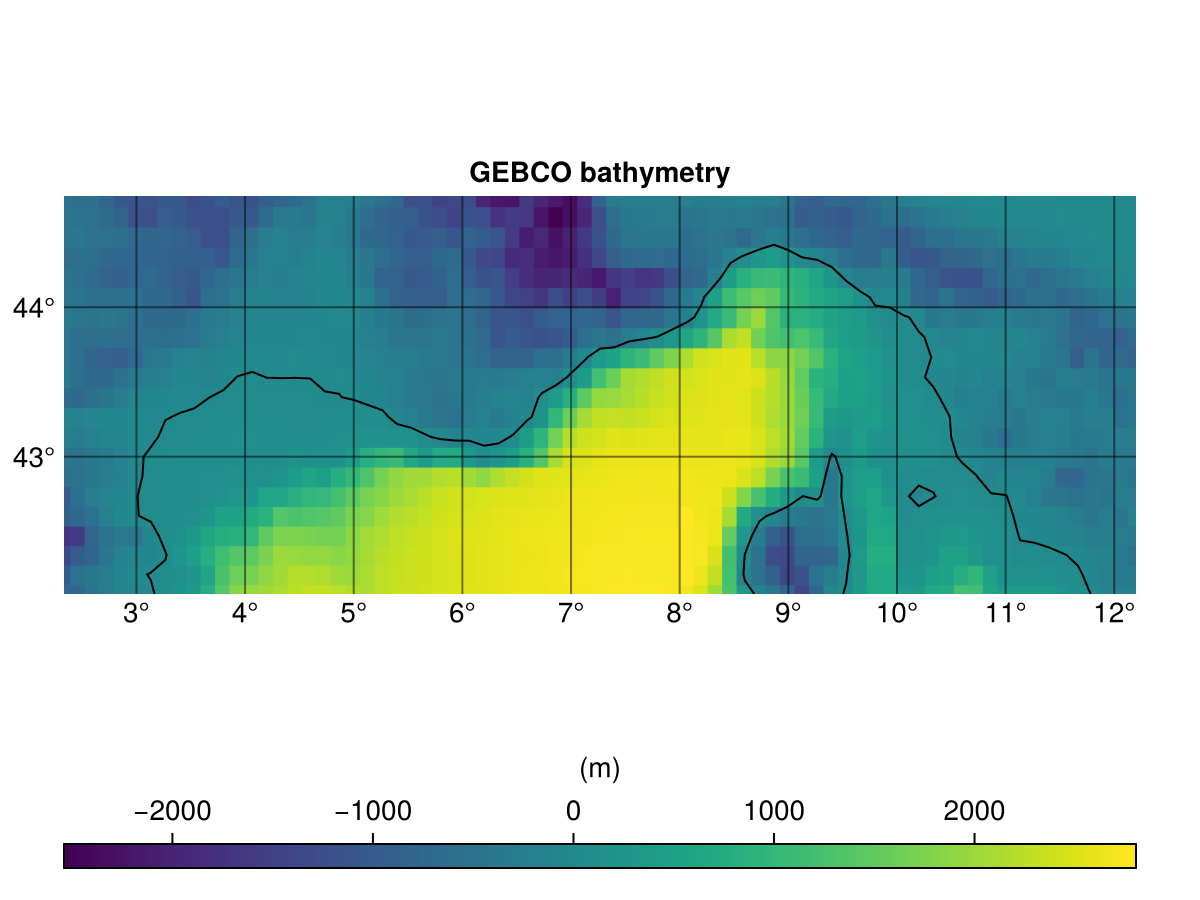

In [5]:
plot_bathy(bx, by, b)

## Load bathymetry
With a change of its original resolution

In [6]:
?load_bath

search: load_bath Base.load_path load_mask plot_bathy loadobs extract_bath



```
xi,yi,bath = DIVAnd.load_bath(bath_name,isglobal,xi,yi)
```

Load the bathymetry from the netCDF file `bathname`. The parameter `isglobal` is true if the NetCDF file covers the whole globe and thus the last longitude point can be considered to be right next to the first longitude point. `xi` and `yi` are vectors containing the longitude and latitude grid onto which the bathymetry should be interpolated.


In [7]:
bx,by,b = load_bath(bathname,true,lonr,latr)

(2.5:0.125:12.0, 42.3:0.125:44.55, [-838.7282714496196 -1282.6898192624344 … -515.0614013807053 -488.3090820343997; -658.6037597263213 -751.0815429460788 … -571.7217407318713 -555.3107605031687; … ; -152.89343262428827 -225.4213561965916 … -14.633590698544474 -3.807708740298319; -265.324218764345 -279.61010742833327 … -6.7736816406319384 -2.1191406250267733])

### Plot

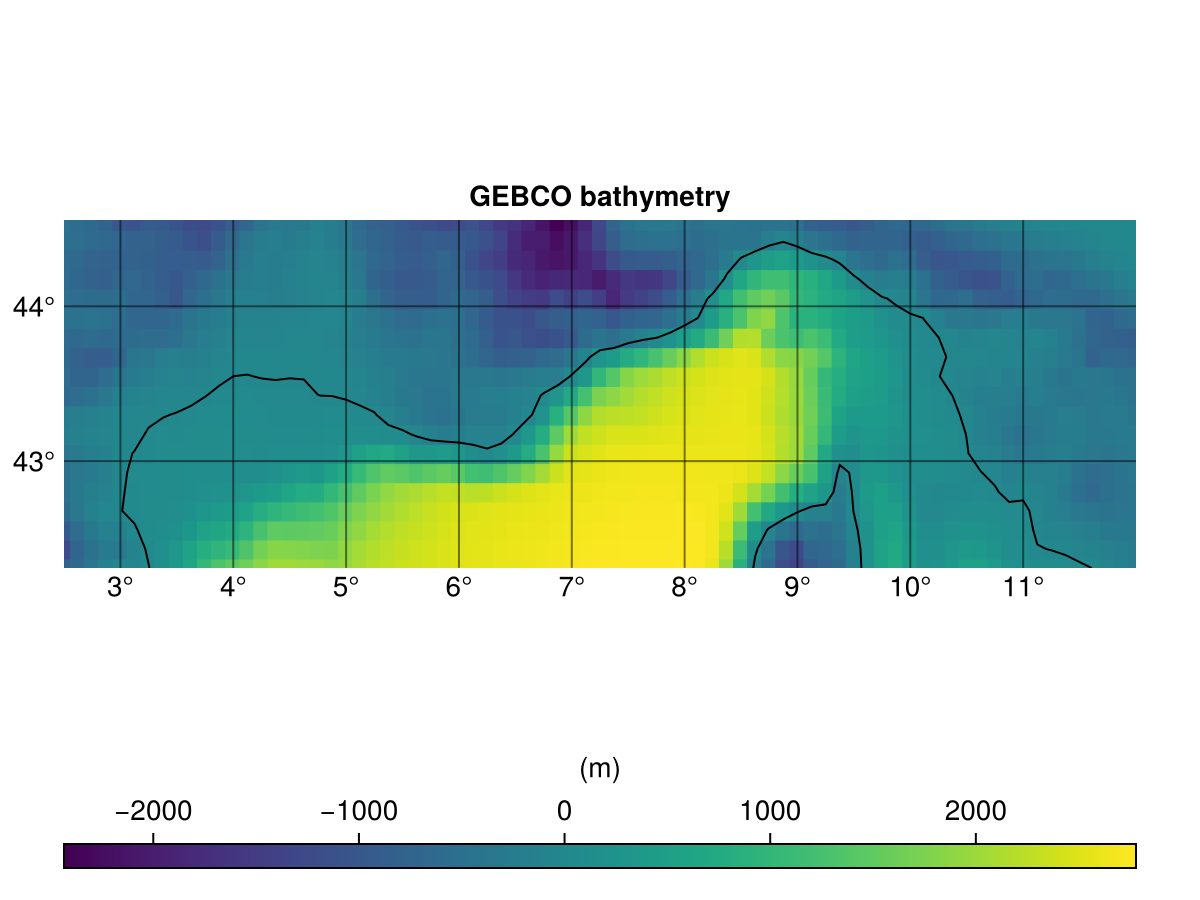

In [8]:
plot_bathy(bx, by, b)

## Mask creation
The land-sea mask delimitates the region where the interpolation will be performed. It is a 3 dimensional binary matrix.

### Using a loop on the depth levels
We start by defining the mask as a 3D matrix containing only `false` values, then we set the values to `true` when the actual depth is deeper than the selected values stored in the vector `depthr`.

In [9]:
mask = falses(size(b,1),size(b,2),length(depthr))

for k = 1:length(depthr)
    for j = 1:size(b,2)
        for i = 1:size(b,1)
            mask[i,j,k] = b[i,j] >= depthr[k]
        end
    end
end
@show typeof(mask)

typeof(mask) = BitArray{3}


BitArray{3}

The mask can be represented at any depth from the provided list of depth `depthr`.

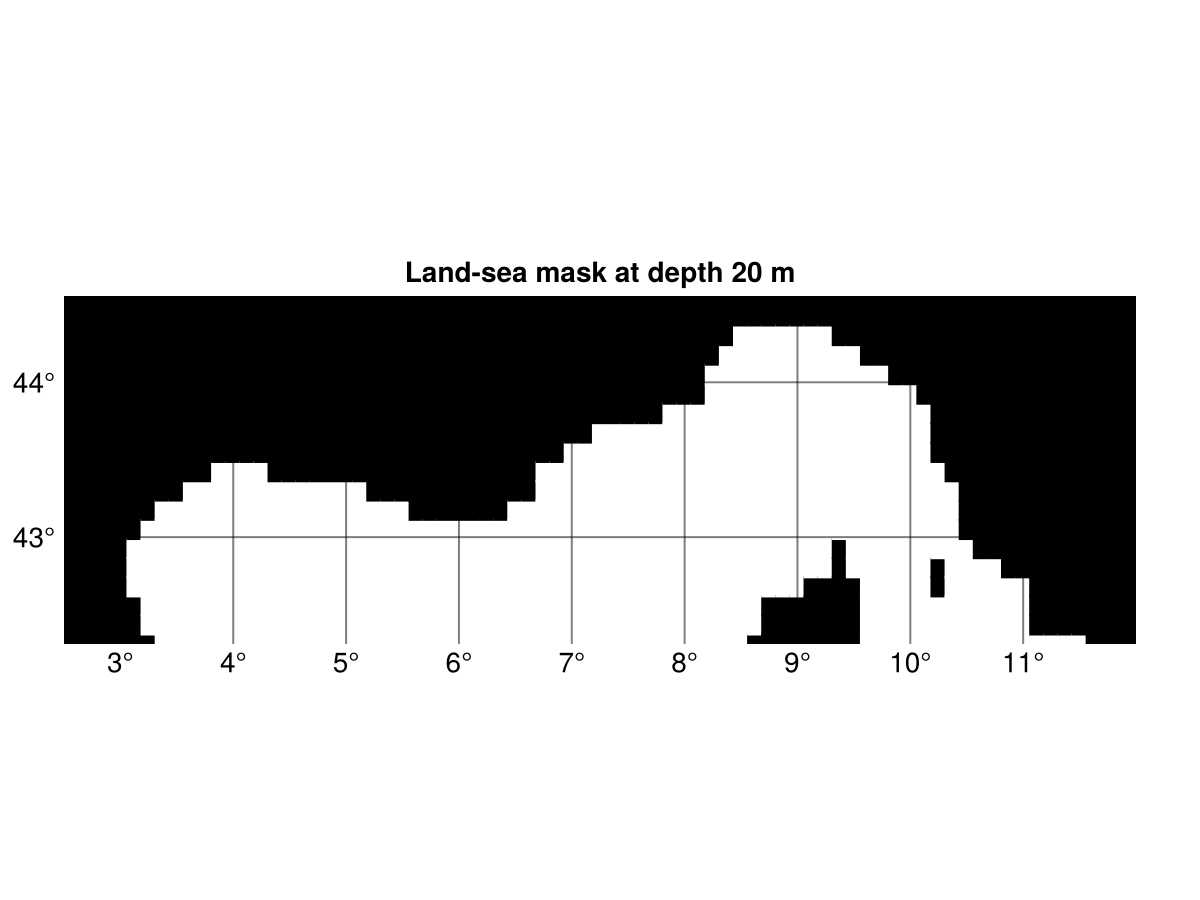

In [10]:
NN = 3
plot_mask(bx, by, mask[:,:,NN], depth=depthr[NN])

### Using the `load_mask` function
A more direct solution is to use the `load_mask` function, where we provide the bathymetry, the grid and the depth levels as inputs.

In [11]:
xmask,ymask,mmask = load_mask(bathname,true,lonr,latr,depthr);

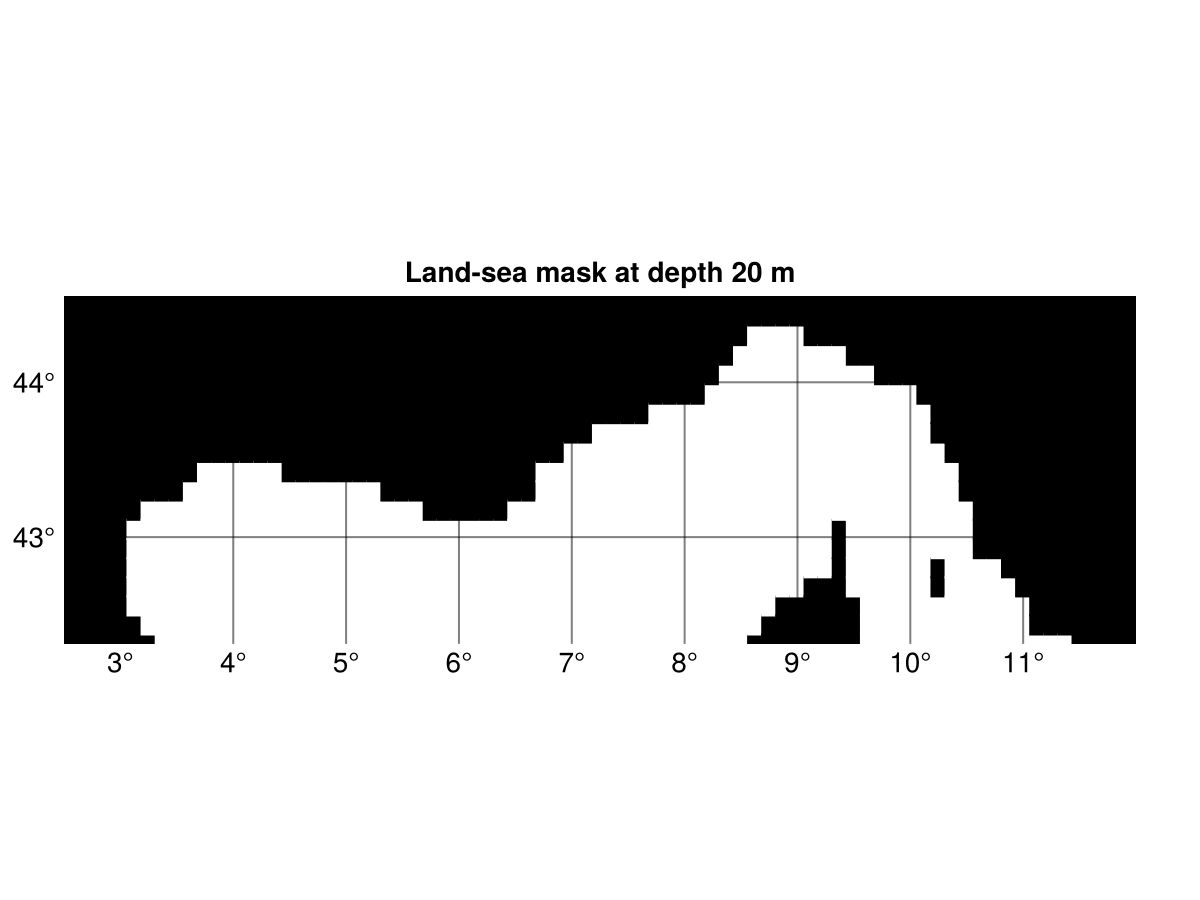

In [12]:
NN = 3
plot_mask(bx, by, mmask[:,:,NN], depth=depthr[NN])

## Flood filling
This tool allows user to remove small lakes or islands.     
To demonstrate it, we add an artificial make on land.

In [13]:
mask[3,3,1] = true

true

## Mask editing
To edit the mask, you can either 
- modify directly its values if you know the indices, or
- use a selection based on the coordinates.
### Create an artificial island
We simply modify the mask at a given location.

In [14]:
# Create a copy of the mask for ediding
mask_copy = copy(mask);
mask_copy[63,8,:] .= false;

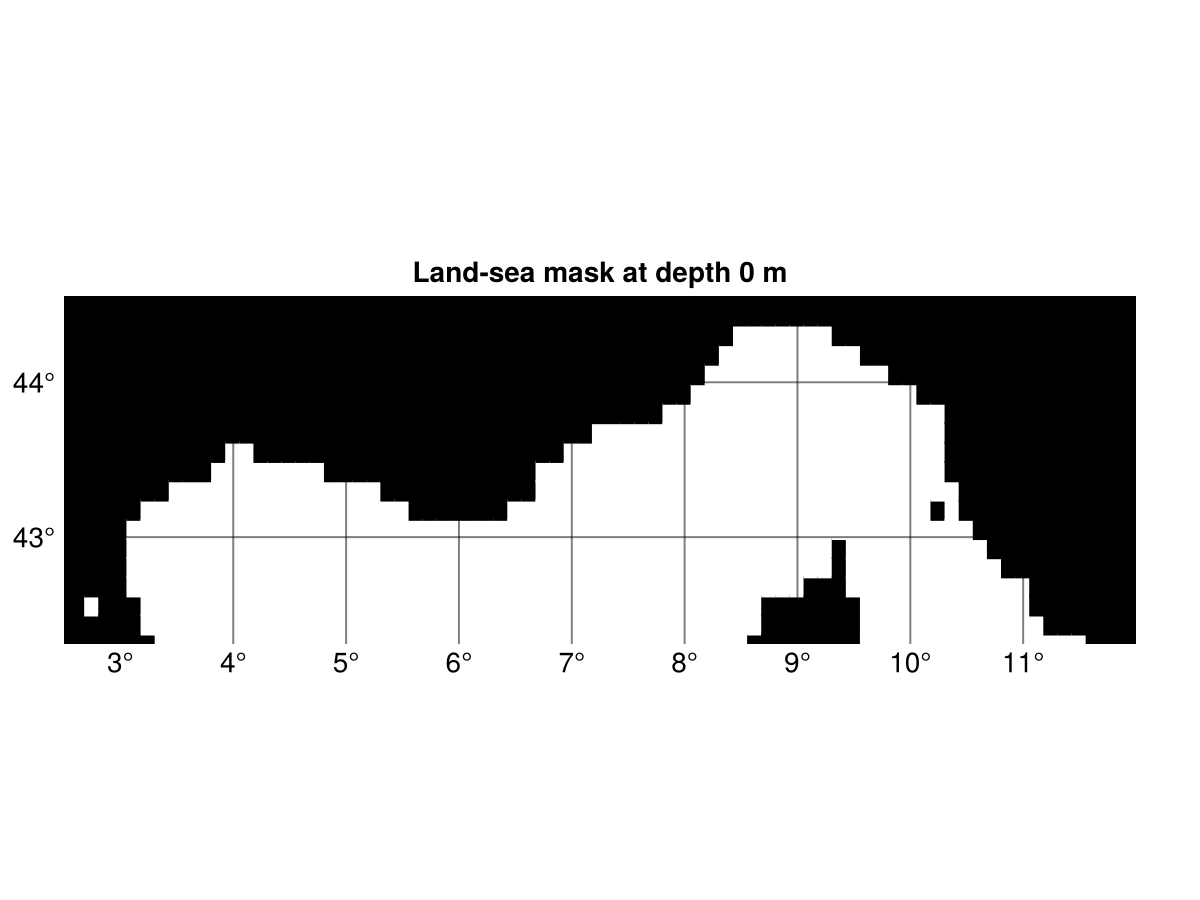

In [15]:
plot_mask(bx, by,mask_copy[:,:,1], depth=depthr[1])

### Remove an island (based on indices)

In [16]:
mask_copy = copy(mask);
mask_copy[48:59,1:10,:] .= true;

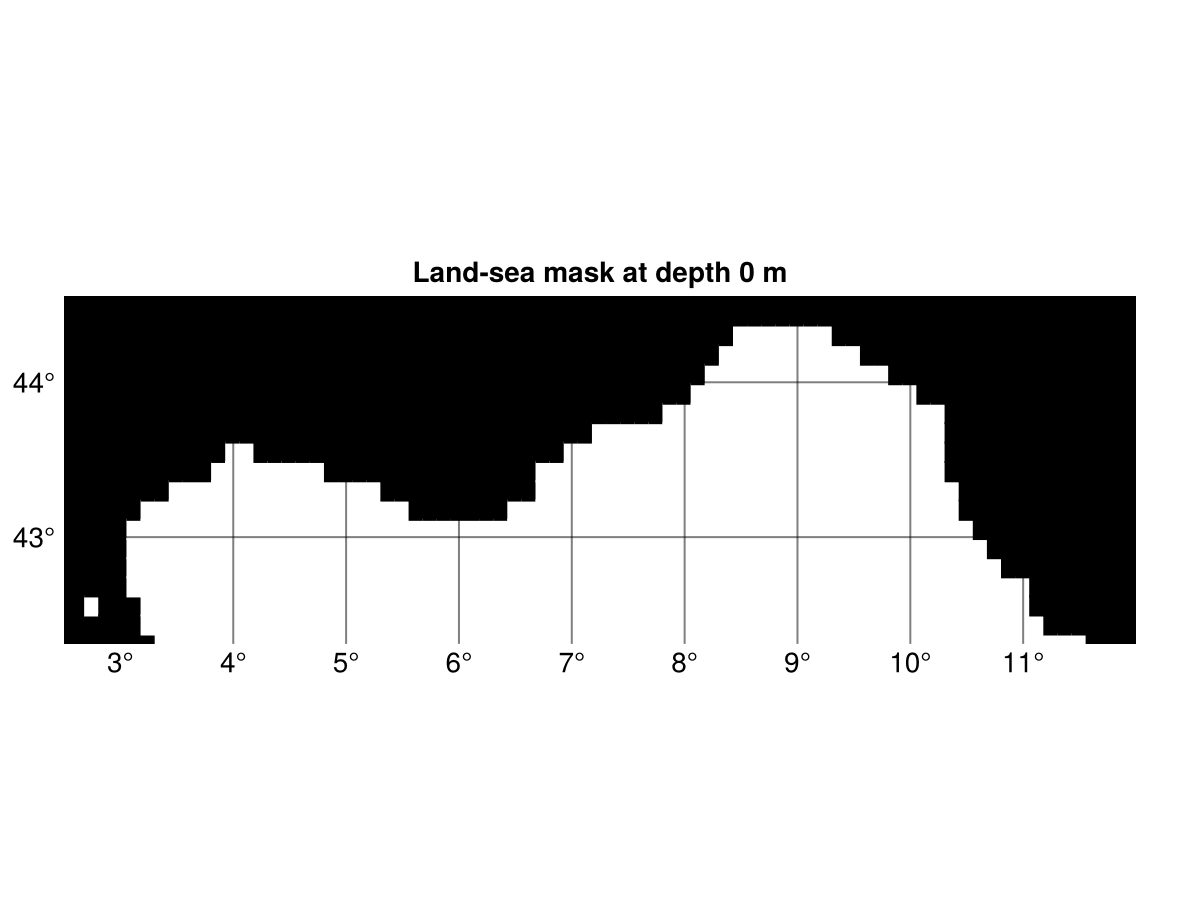

In [17]:
plot_mask(bx, by, mask_copy[:,:,1], depth=depthr[1])

### Remove an island (based on coordinates). 

This is the recommended approach as you can change resolution easily
`sel_lon` and `sel_lat` are obtained by checking the longitude and latitudes.

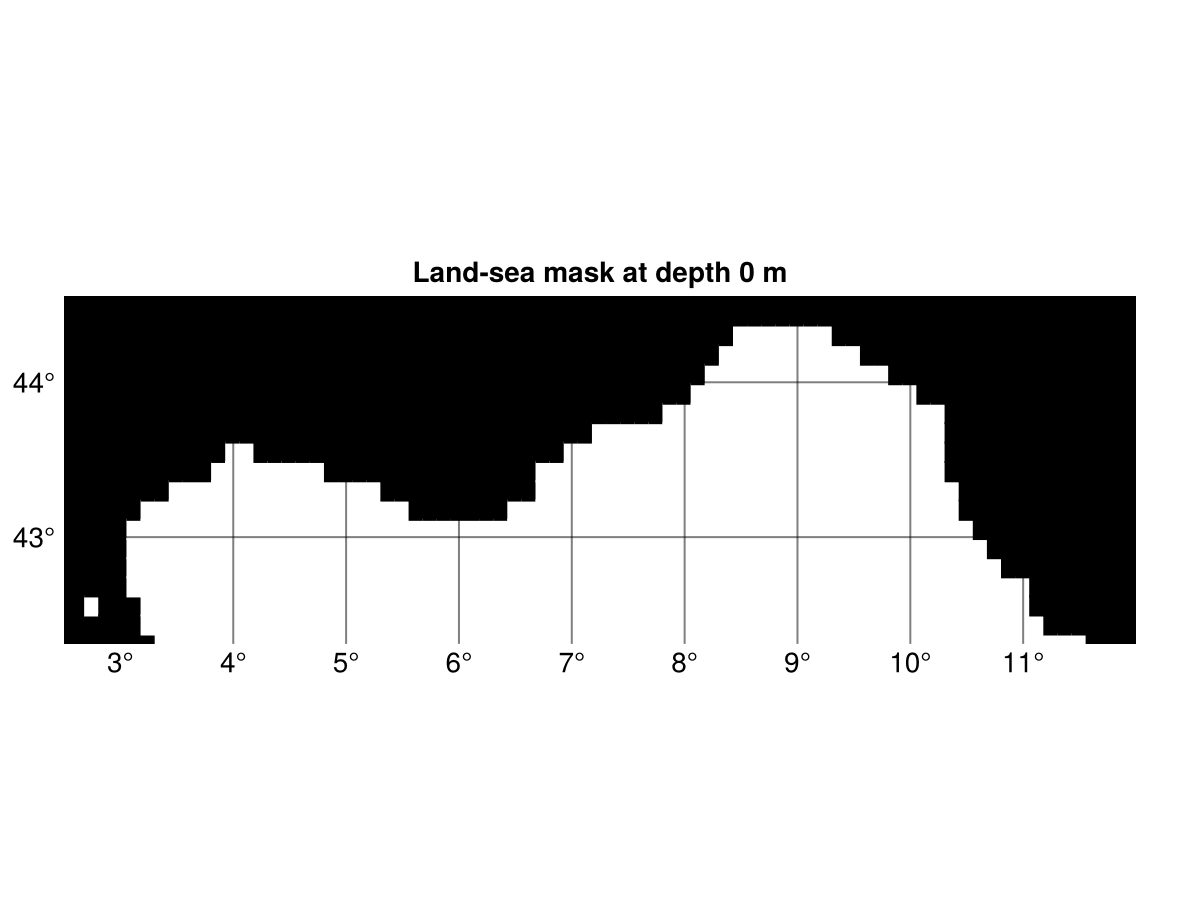

In [18]:
mask_copy = copy(mask);
sel_lon = (bx.>8) .& (bx.<10.);
sel_lat = (by.<43.25);
mask_copy[sel_lon, sel_lat, :] .= true;

plot_mask(bx, by, mask_copy[:,:,1], depth=depthr[1])

### Removing isolated sea pixels
Let's edit the previous mask and add an isolated sea point in the western part of the domain.    

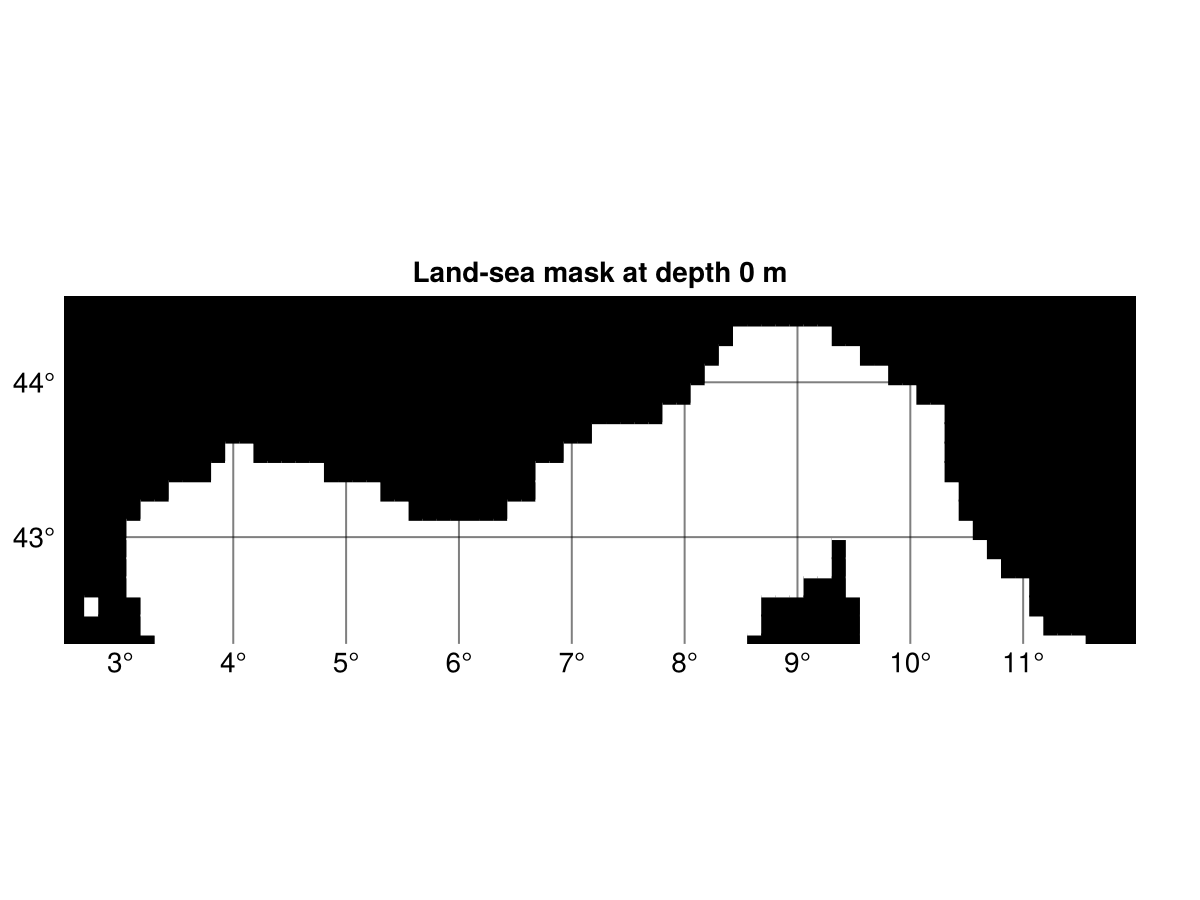

In [19]:
mask[3,3,1] = true
plot_mask(bx, by, mask[:,:,1], depth=depthr[1])

The function `floofill` can help us identify the position of this pixel:

Let's plot the `label` values as obtained by the execution of `floodfill`:

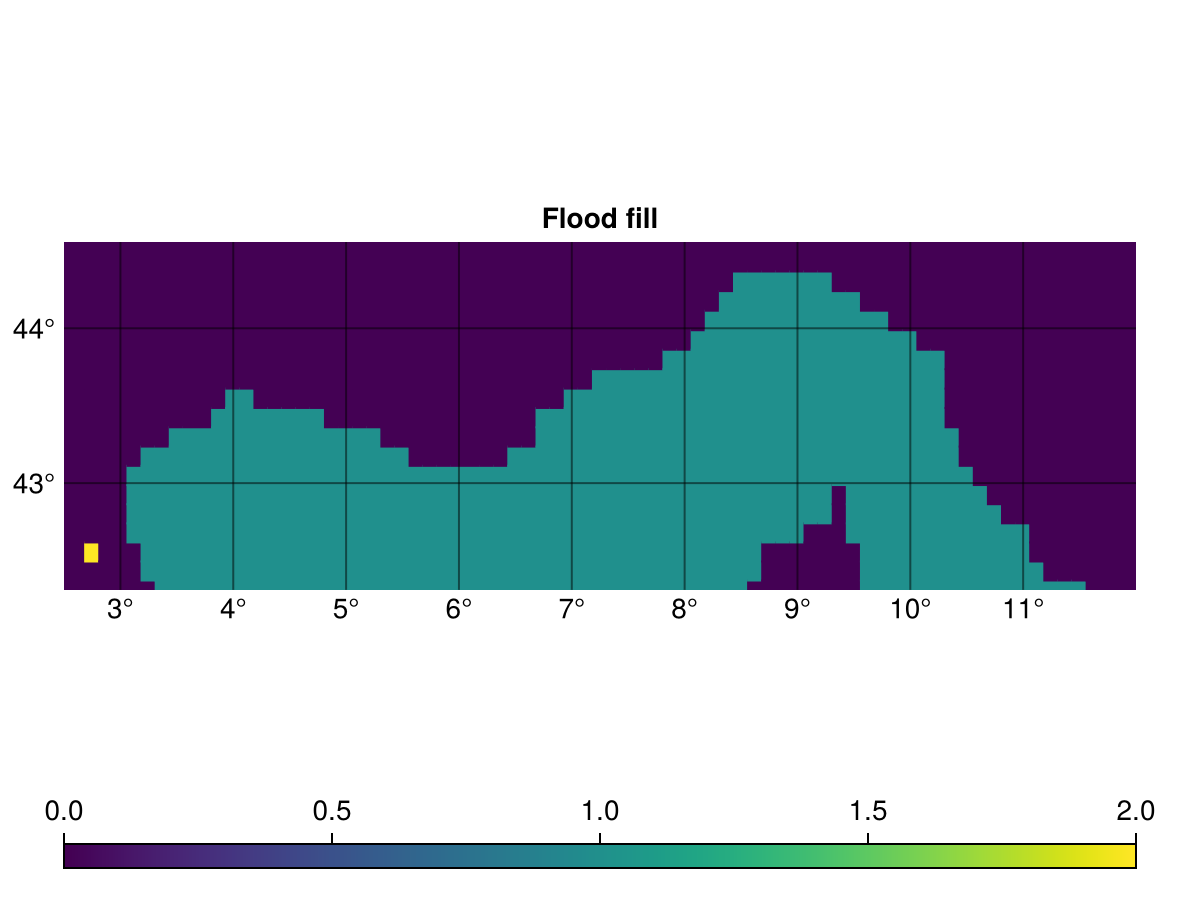

In [20]:
label = DIVAnd.floodfill(mask)

fig = Figure()
ga = GeoAxis(fig[1, 1];  dest = "+proj=merc", title = "Flood fill", xticks=2.:1.:14, yticks=42.:1.:45.)
hm = heatmap!(ga, bx, by, label[:,:,1], interpolate = false)
xlims!(ga, (bx[1], bx[end]))
ylims!(ga, (by[1], by[end]))
Colorbar(fig[2, 1], hm, vertical = false)
fig

We see that the isolated sea point is characterised by `label = 2`,        
hence we can discard it by taking the cells for which `label = 1`.

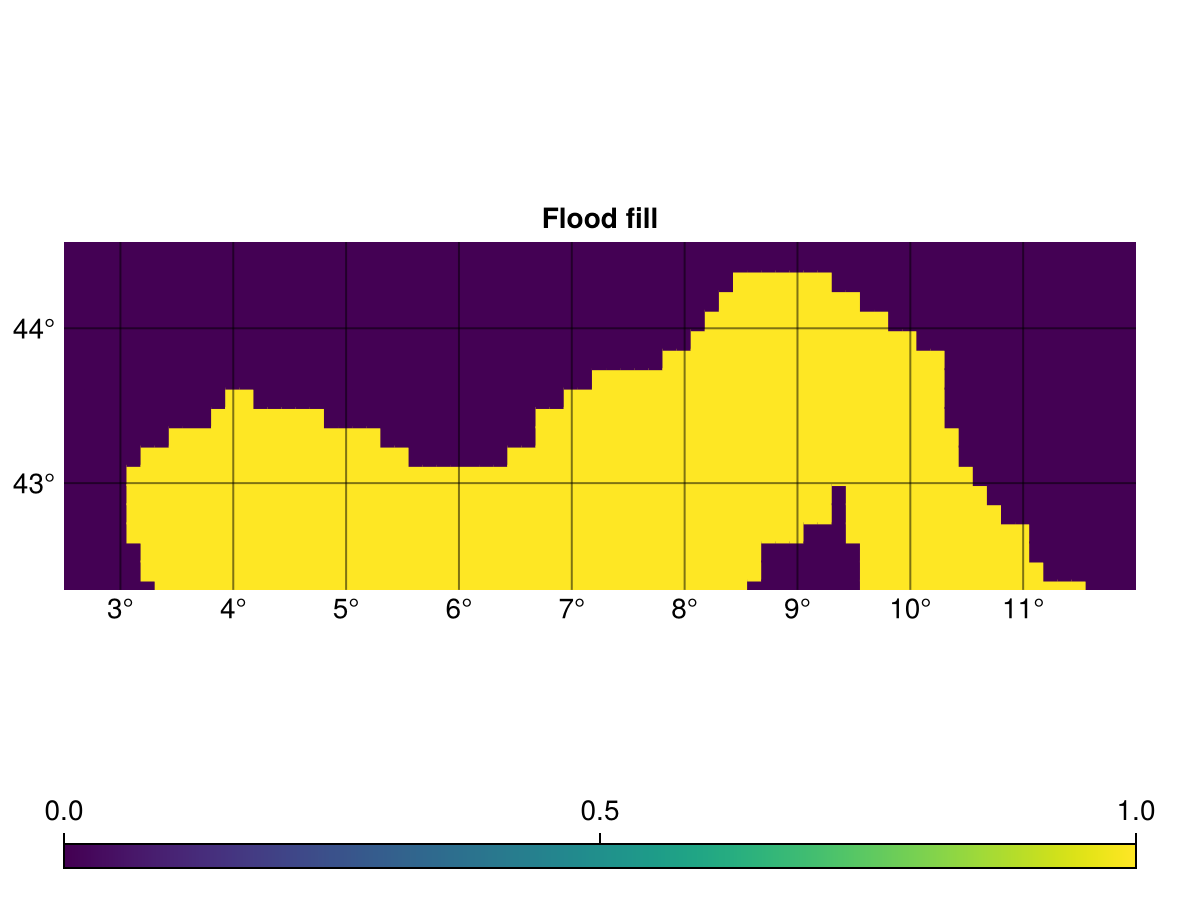

In [21]:
mask3 = label .== 1

fig = Figure()
ga = GeoAxis(fig[1, 1];  dest = "+proj=merc", title = "Flood fill", xticks=2.:1.:14, yticks=42.:1.:45.)
hm = heatmap!(ga, bx, by, mask3[:,:,1], interpolate = false)
xlims!(ga, (bx[1], bx[end]))
ylims!(ga, (by[1], by[end]))
Colorbar(fig[2, 1], hm, vertical = false)
fig

## Exercice
1. Load the bathymetry around the Black Sea.
2. Create a land sea mask for the following levels: 0, 150, 500 and 1000 meters.
3. Remove the Sea of Azov and the Sea of Marmara.
4. Plot the result.

The solution is available in [06-topography-BlackSea](./solutions/06-topography-BlackSea.ipynb) and should look like this:

<img src="./Images/BlackSea_mask.png" width="250px">

## Adapt your own bathymetry (advanced)

To use a local bathymetry, one needs to create a netCDF file which has a similar structure than GEBCO files.
In particular, the netCDF file is expected to have the one-dimensional variables `lon` (longitude in _degrees East_) and `lat` (latitude in _degrees North_), and the two-dimentional array `bat` containing the digital terrain model (negative in water and positive above water). 

The order of the dimensions should be: longitude and then latitude in *Column-major* ordering (or latitude and then longitude if the tool ncdump is used, which is based on *Row-major* ordering).

The module `NCDatasets`, provide the utility function `ncgen` which returns the Julia code that creates a netCDF file with the same metadata:

In [22]:
using NCDatasets
ncgen(bathname)

using NCDatasets, DataStructures
ds = NCDataset("filename.nc","c", attrib = OrderedDict(
    "title"                     => "GEBCO",
))

# Dimensions

ds.dim["lat"] = 1352
ds.dim["lon"] = 2700

# Declare variables

nclat = defVar(ds,"lat", Float64, ("lat",), attrib = OrderedDict(
    "long_name"                 => "Latitude",
    "standard_name"             => "latitude",
    "units"                     => "degrees_north",
))

nclon = defVar(ds,"lon", Float64, ("lon",), attrib = OrderedDict(
    "long_name"                 => "Longitude",
    "standard_name"             => "longitude",
    "units"                     => "degrees_east",
))

ncbat = defVar(ds,"bat", Float32, ("lon", "lat"), attrib = OrderedDict(
    "long_name"                 => "elevation above sea level",
    "standard_name"             => "height",
    "units"                     => "meters",
))


# Define variables

# nclat[:] = ...
# nclon[:] = ...
# ncbat[:,:] = ...

close(ds)


closed Dataset

In this example, one would need to adapt:
* the title attribute of the NetCDF file 
* the size of the dimensions
* define the variables `nclon`, `nclat` and `ncbat`

With this code, you only have to use the coordinates and the bathymetry read from your own file to generate the new bathymetry file.